In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
from dask.distributed import Client

In [3]:
client =Client(n_workers=8, threads_per_worker=1, memory_limit="4 GiB")
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 8,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:58921,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:50565,Total threads: 1
Dashboard: http://127.0.0.1:38720/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:42647,


In [4]:
from metpy import calc  as mc
from metpy.units import units

In [5]:
output_path = "/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/ICE-CHANEL/viz/ACCESS-CM2/"

In [34]:
monthly_temp_max = xr.open_mfdataset(output_path+"monthly/tasmax_day_ACCESS-CM_*.nc",chunks={"time":1})#,"lat":300,'lon':10})
monthly_temp = xr.open_mfdataset(output_path+"monthly/tas_day_ACCESS-CM_*.nc",chunks={"time":1})#,"lat":300,'lon':10})
monthly_huss = xr.open_mfdataset(output_path+"monthly/huss_day_ACCESS-CM_*.nc",chunks={"time":1})#,"lat":300,'lon':10})

In [35]:
temp =  monthly_temp.tas.isel(time=0).metpy.convert_units('degF')
spe_hum = monthly_huss.huss.isel(time=0)

In [36]:
dew_point = mc.dewpoint_from_specific_humidity(1013.25 * units.hPa, monthly_huss.huss.isel(time=0) * units('kg/kg'))

In [37]:
rel_hum =mc.relative_humidity_from_specific_humidity(1013.25 * units.hPa, temp , spe_hum * units('kg/kg'))

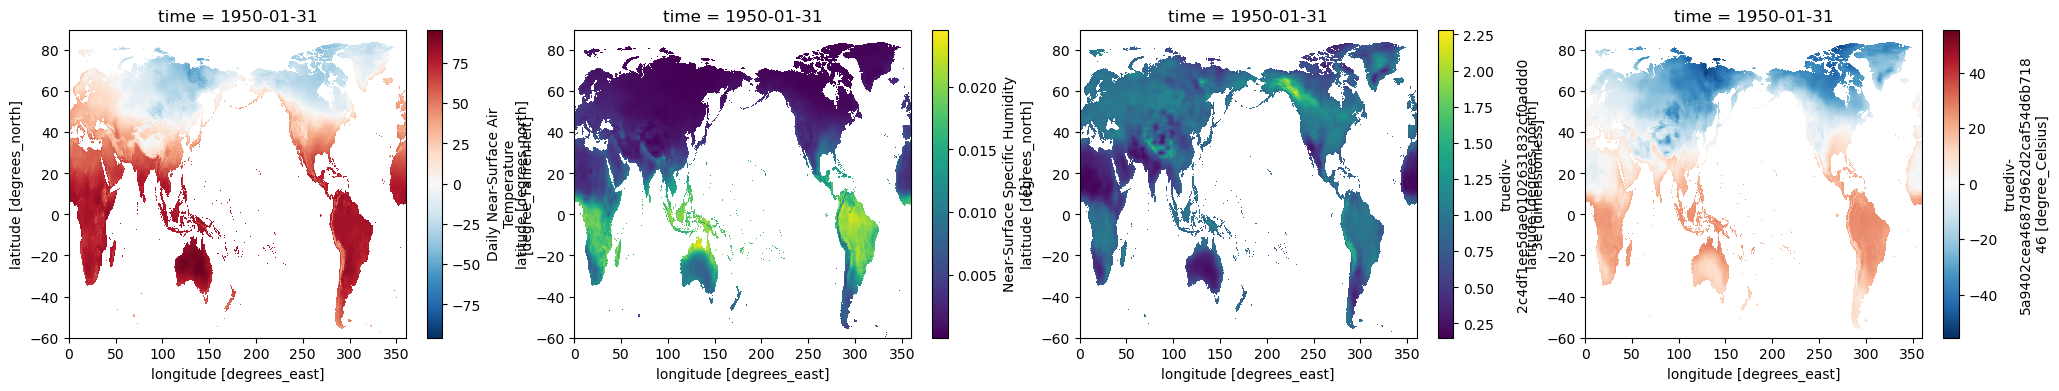

In [41]:
fig,ax = plt.subplots(1,4,figsize=(25,4))

temp.plot(ax=ax[0])
spe_hum.plot(ax=ax[1])
rel_hum.plot(ax=ax[2])
dew_point.plot(ax=ax[3])

In [17]:
# %%time
# a = mc.wet_bulb_temperature(1013.25 * units.hPa, np.zeros(8640)+300 * units.degK, np.zeros(8640)+10 * units.degC)

In [18]:
# temp.shape

In [19]:
# wet_bulb = mc.wet_bulb_temperature(1013.25 * units.hPa, temp, dew)

In [20]:
# wet_bulb.plot()

In [21]:
HI = mc.heat_index(temp.values* units.degF, rel_hum.fillna(0).values)

In [22]:
def convert_todegC(temp_degF):
    return (( temp_degF.magnitude.data - 32 ) * 5/9 )

def compute_HI( temp, specific_hum, pres=1013.25* units.hPa):
    rel_hum =mc.relative_humidity_from_specific_humidity(pres, temp , spe_hum )
    HI = mc.heat_index(temp.values* units.degF, rel_hum.fillna(0).values)
    return convert_todegC(HI)

def HI_risk(HI):
    HI_r =  ( HI-27 ) / (54 - 27) 
    HI_r[HI_r < 0 ] = 0 
    return HI_r

In [23]:
temp =  monthly_temp.tas.isel(time=0).metpy.convert_units('degF')
spe_hum = monthly_huss.huss.isel(time=0)

d1950 = compute_HI(temp, spe_hum)

temp =  monthly_temp.tas.isel(time=-1).metpy.convert_units('degF')
spe_hum = monthly_huss.huss.isel(time=-1)

d2100 = compute_HI(temp, spe_hum)

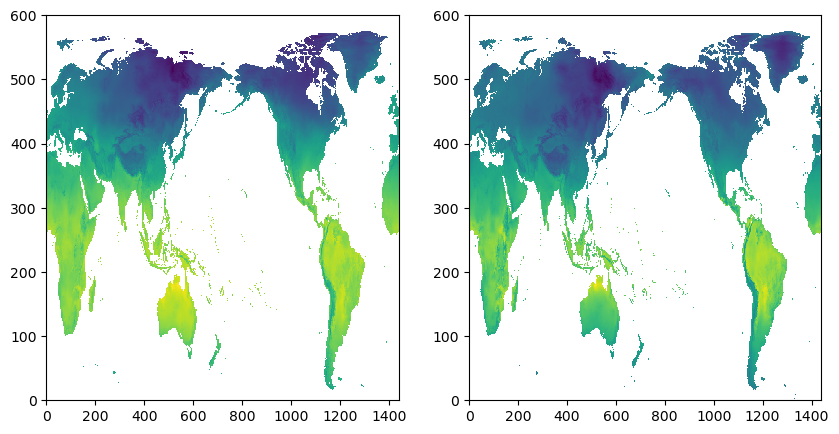

In [24]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].pcolormesh(d1950)
ax[1].pcolormesh(d2100)

In [6]:
output_path = "/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/ICE-CHANEL/viz/ACCESS-CM2/"

In [7]:
# years = np.unique(monthly_temp_max['time.year'])
# output_path = "/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/ICE-CHANEL/viz/ACCESS-CM2/"

# for year in years:
#     print(year)
    
#     temp =  monthly_temp.tas.sel(time=str(year)).metpy.convert_units('degF')
#     spe_hum = monthly_huss.huss.sel(time=str(year))

#     year_HI = compute_HI(temp, spe_hum)
#     HI_r = HI_risk(year_HI)
    
#     da_year_HI = temp.copy(data=year_HI).rename('Heat_Index')
#     da_year_HI_r = temp.copy(data=HI_r).rename('Heat_Risk')
    
#     HI_data = xr.merge((da_year_HI,da_year_HI_r))
#     HI_data.to_netcdf(output_path+"monthly/Heat_Index_ACCESS-CM_{0}.nc".format(year))
# #     break

In [8]:
HI_data = xr.open_mfdataset(output_path+"monthly/Heat_Index_ACCESS-CM_*.nc")

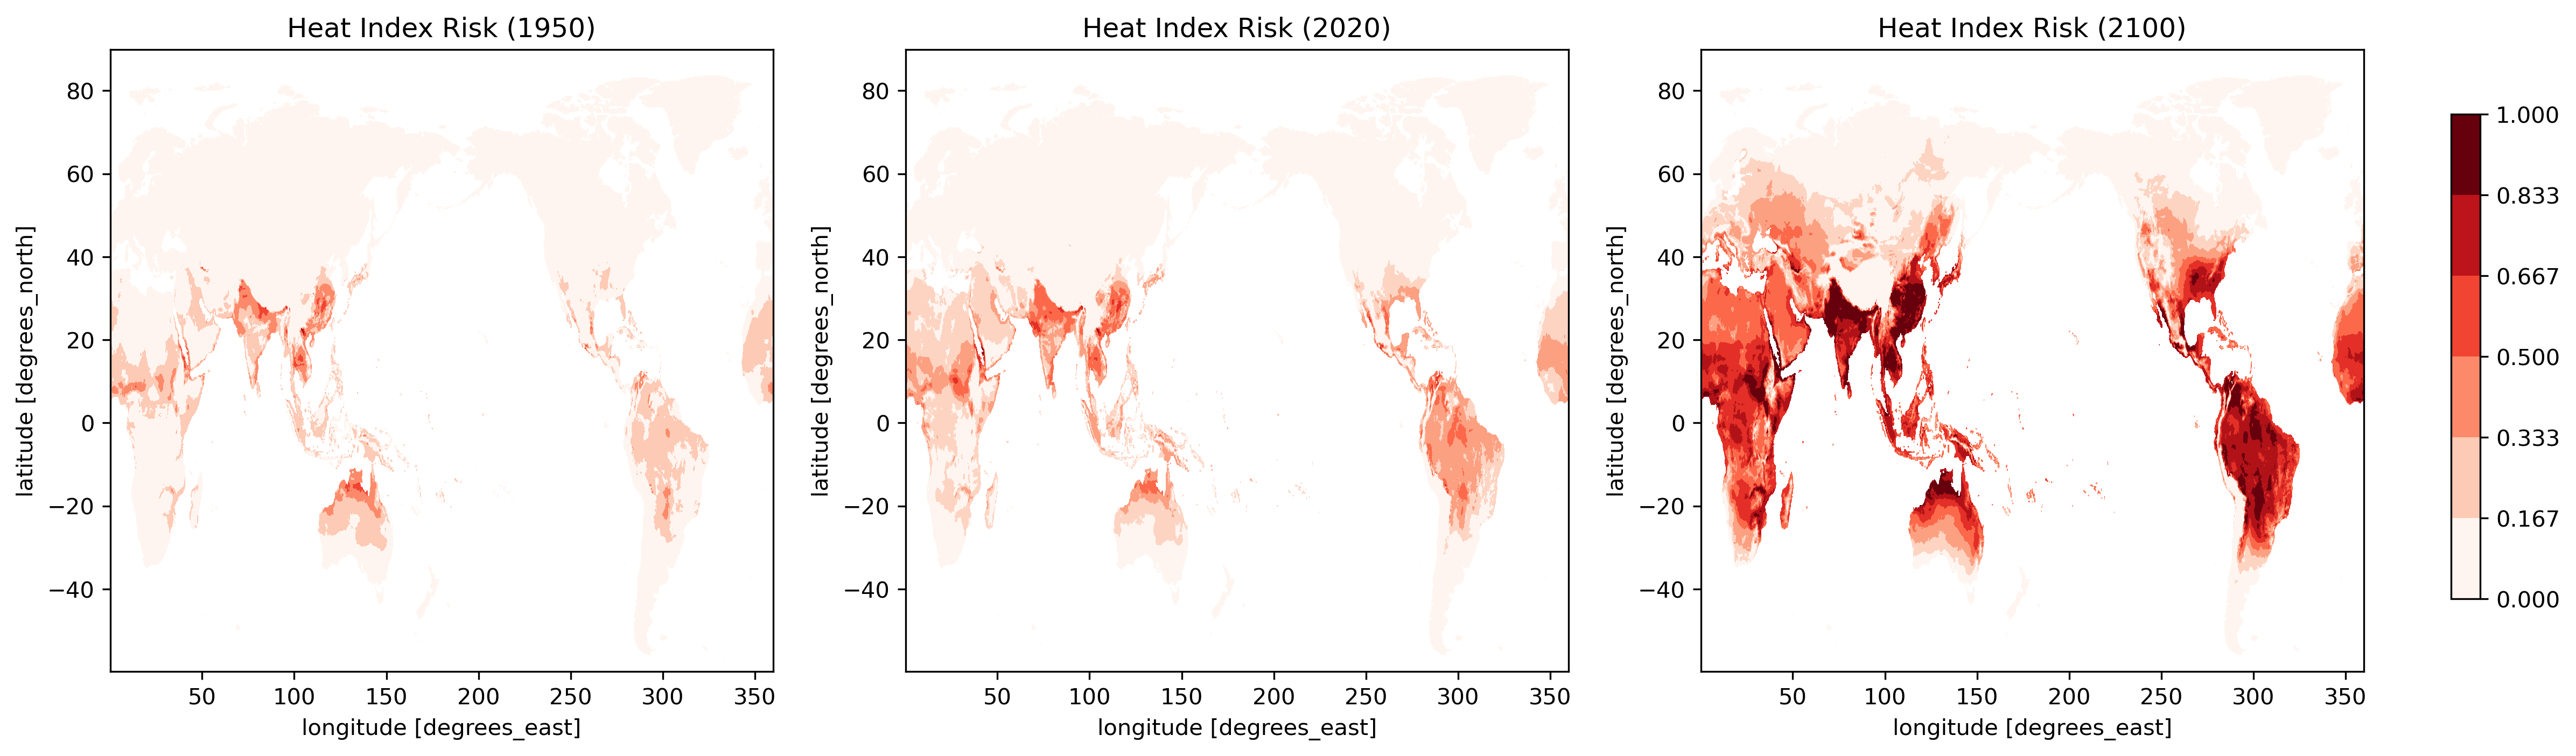

In [9]:
fig,ax = plt.subplots(1,3,figsize=(18,5),dpi=300)

cb = HI_data.Heat_Risk.sel(time="1950").max('time').plot.contourf(ax=ax[0],vmin=0,vmax=1,cmap="Reds",add_colorbar=False)
HI_data.Heat_Risk.sel(time="2020").max('time').plot.contourf(ax=ax[1],vmin=0,vmax=1,cmap="Reds",add_colorbar=False)
HI_data.Heat_Risk.sel(time="2100").max('time').plot.contourf(ax=ax[2],vmin=0,vmax=1,cmap="Reds",add_colorbar=False)

ax[0].set_title('Heat Index Risk (1950)')
ax[1].set_title('Heat Index Risk (2020)')
ax[2].set_title('Heat Index Risk (2100)')

cax = fig.add_axes([0.93, 0.2, 0.01, 0.6])
fig.colorbar(cb, cax=cax)

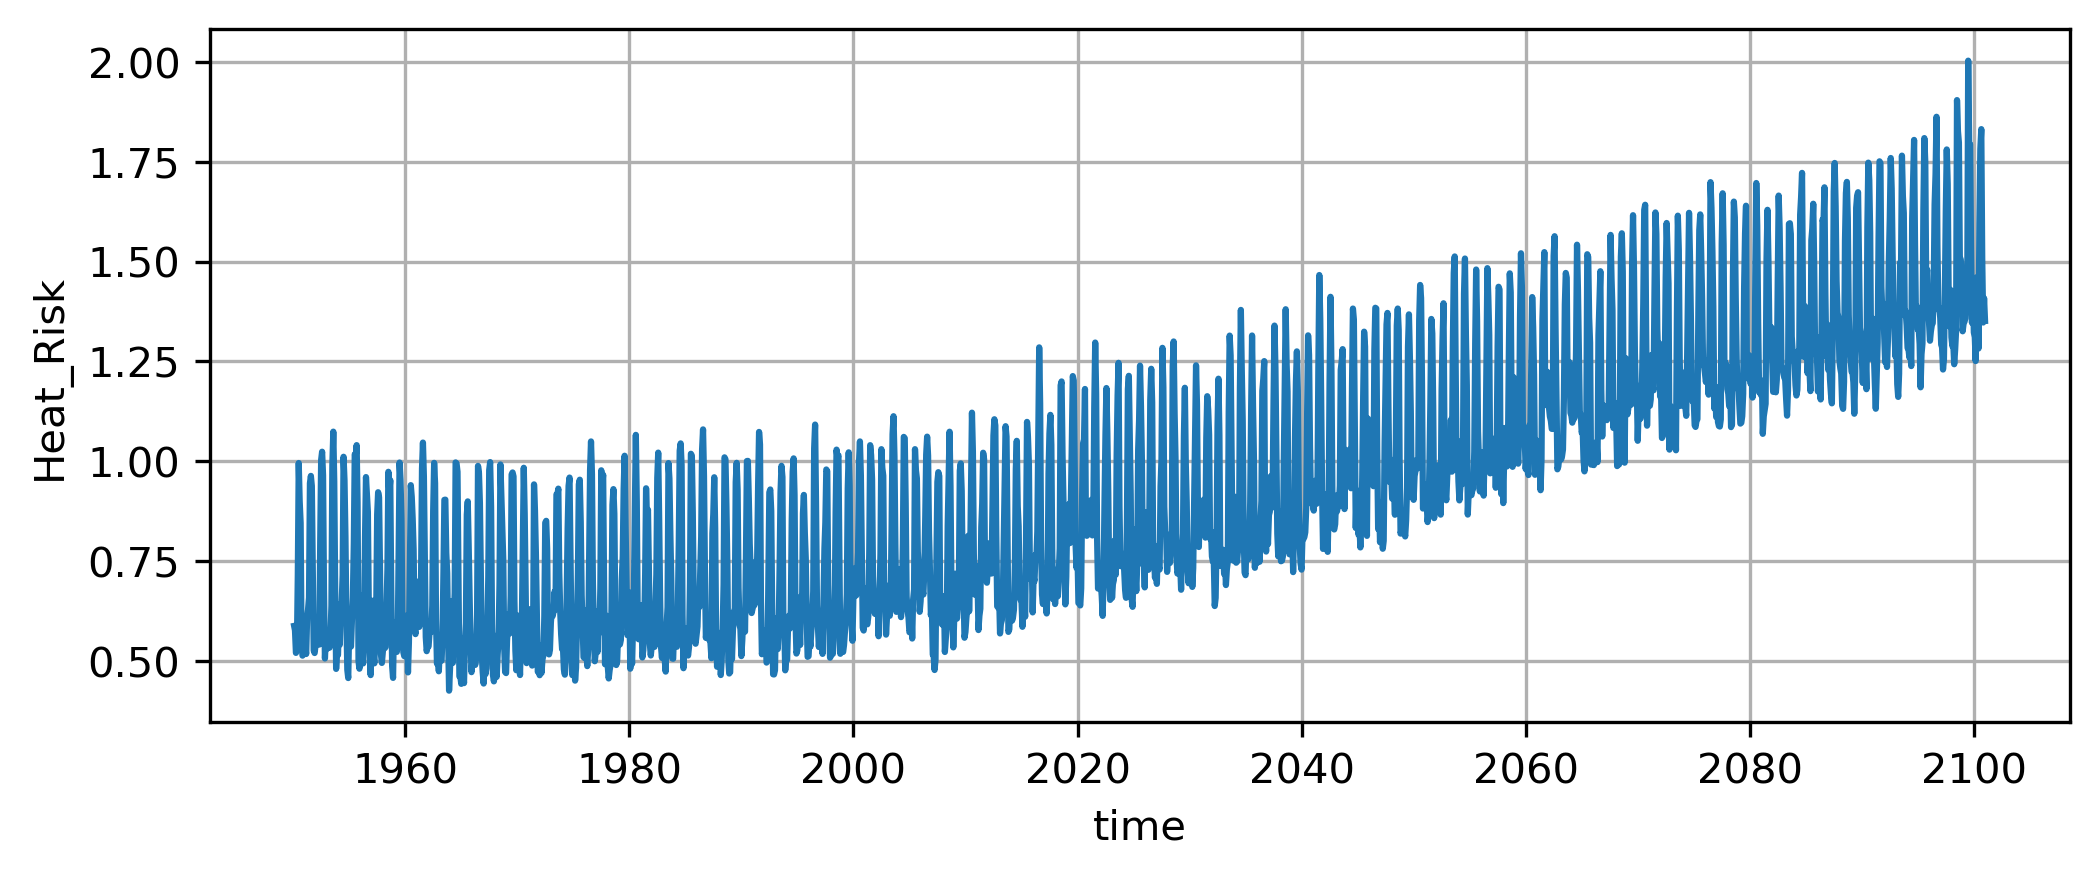

In [10]:
fig,ax = plt.subplots(1,1,figsize=(8,3),dpi=300)

HI_data.Heat_Risk.max(('lat','lon')).plot(ax=ax)

ax.grid()

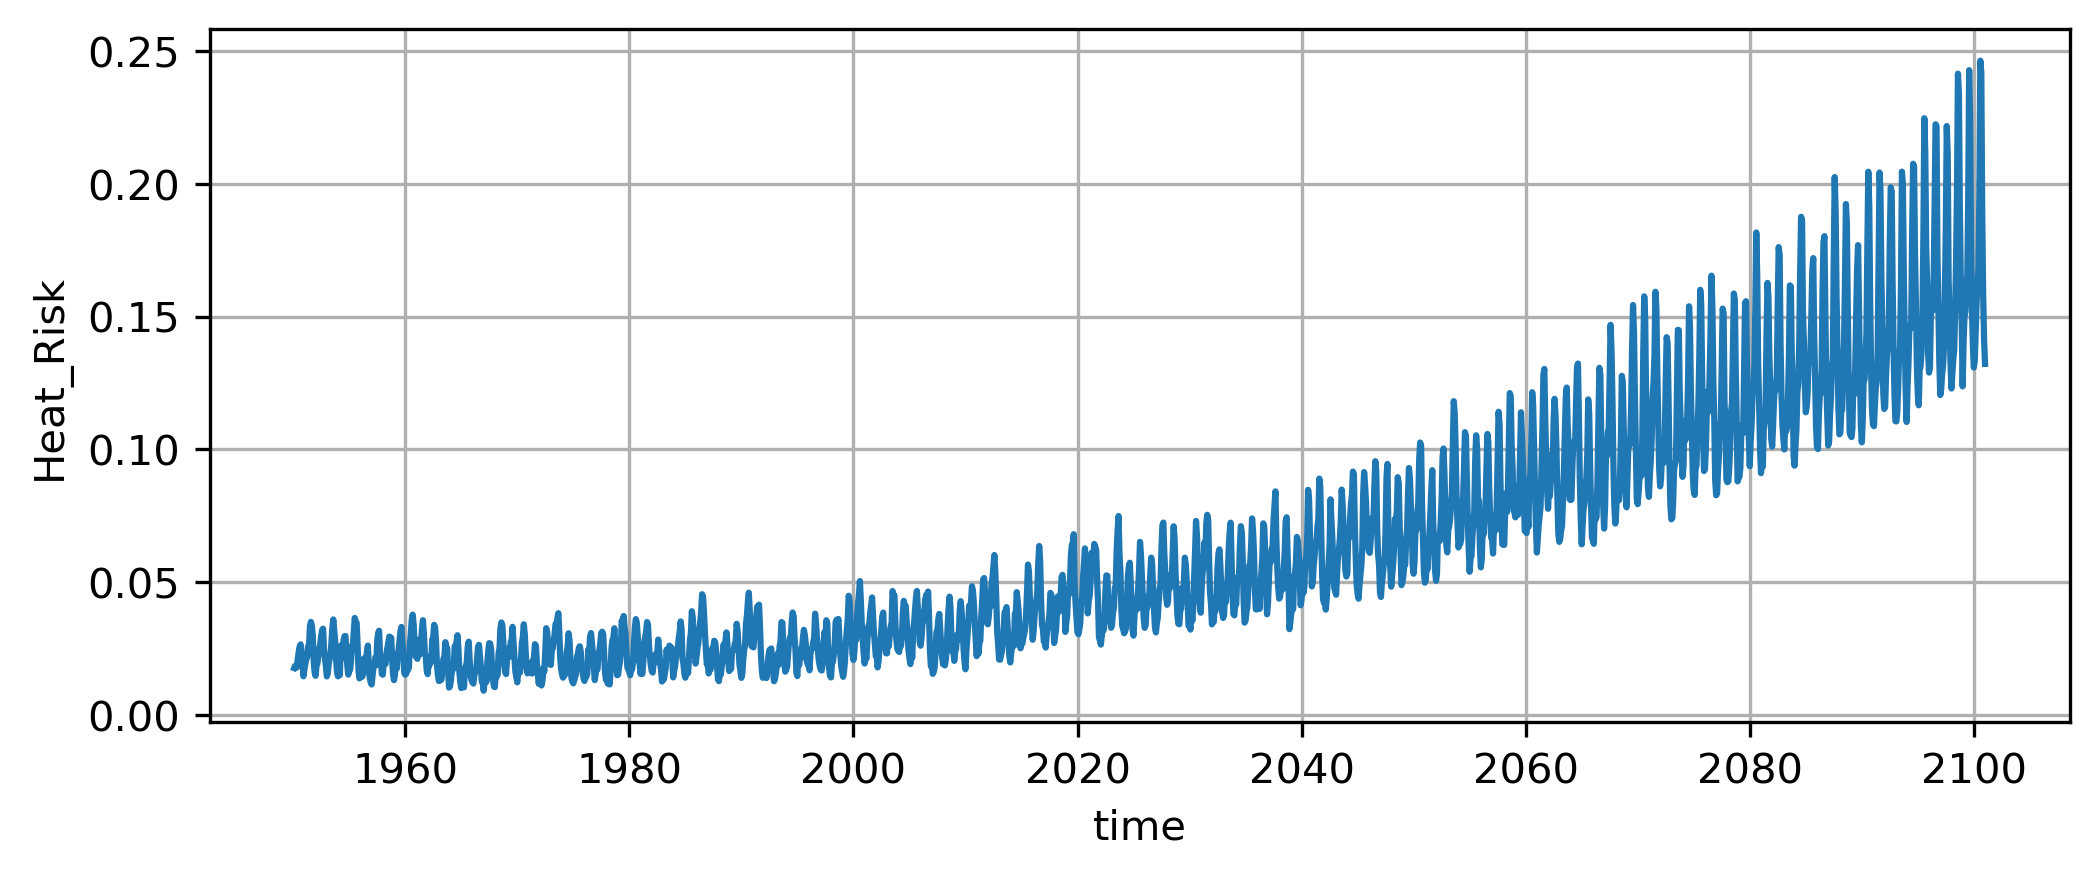

In [48]:
fig,ax = plt.subplots(1,1,figsize=(8,3),dpi=300)

HI_data.Heat_Risk.mean(('lat','lon')).plot(ax=ax)

ax.grid()

In [12]:
from pyproj import Geod

In [17]:
g=Geod(ellps='WGS84')
lon2D,lat2D = np.meshgrid(HI_data.lon,HI_data.lat)
_,_, distEW = g.inv(lon2D[:,:-1],lat2D[:,1:], lon2D[:,1:], lat2D[:,1:])
_,_, distNS = g.inv(lon2D[1:,:],lat2D[1:,:], lon2D[1:,:], lat2D[:-1,:])
pixel_area = distEW[1:,:] * distNS[:,1:] 
area = np.zeros(np.shape(lon2D))

In [19]:
area[:-1,:-1] = pixel_area
area[-1,:-1] = pixel_area[-1,:]
area[:-1,-1] = pixel_area[:,-1]

In [23]:
area_HI = (HI_data.Heat_Risk.where(HI_data.Heat_Risk>0.5,0).where(HI_data.Heat_Risk<0.5,1).where(np.isfinite(HI_data.Heat_Risk))*area)

In [29]:
area_ = (area_HI.sum(("lon","lat")) * 1e-6).compute()

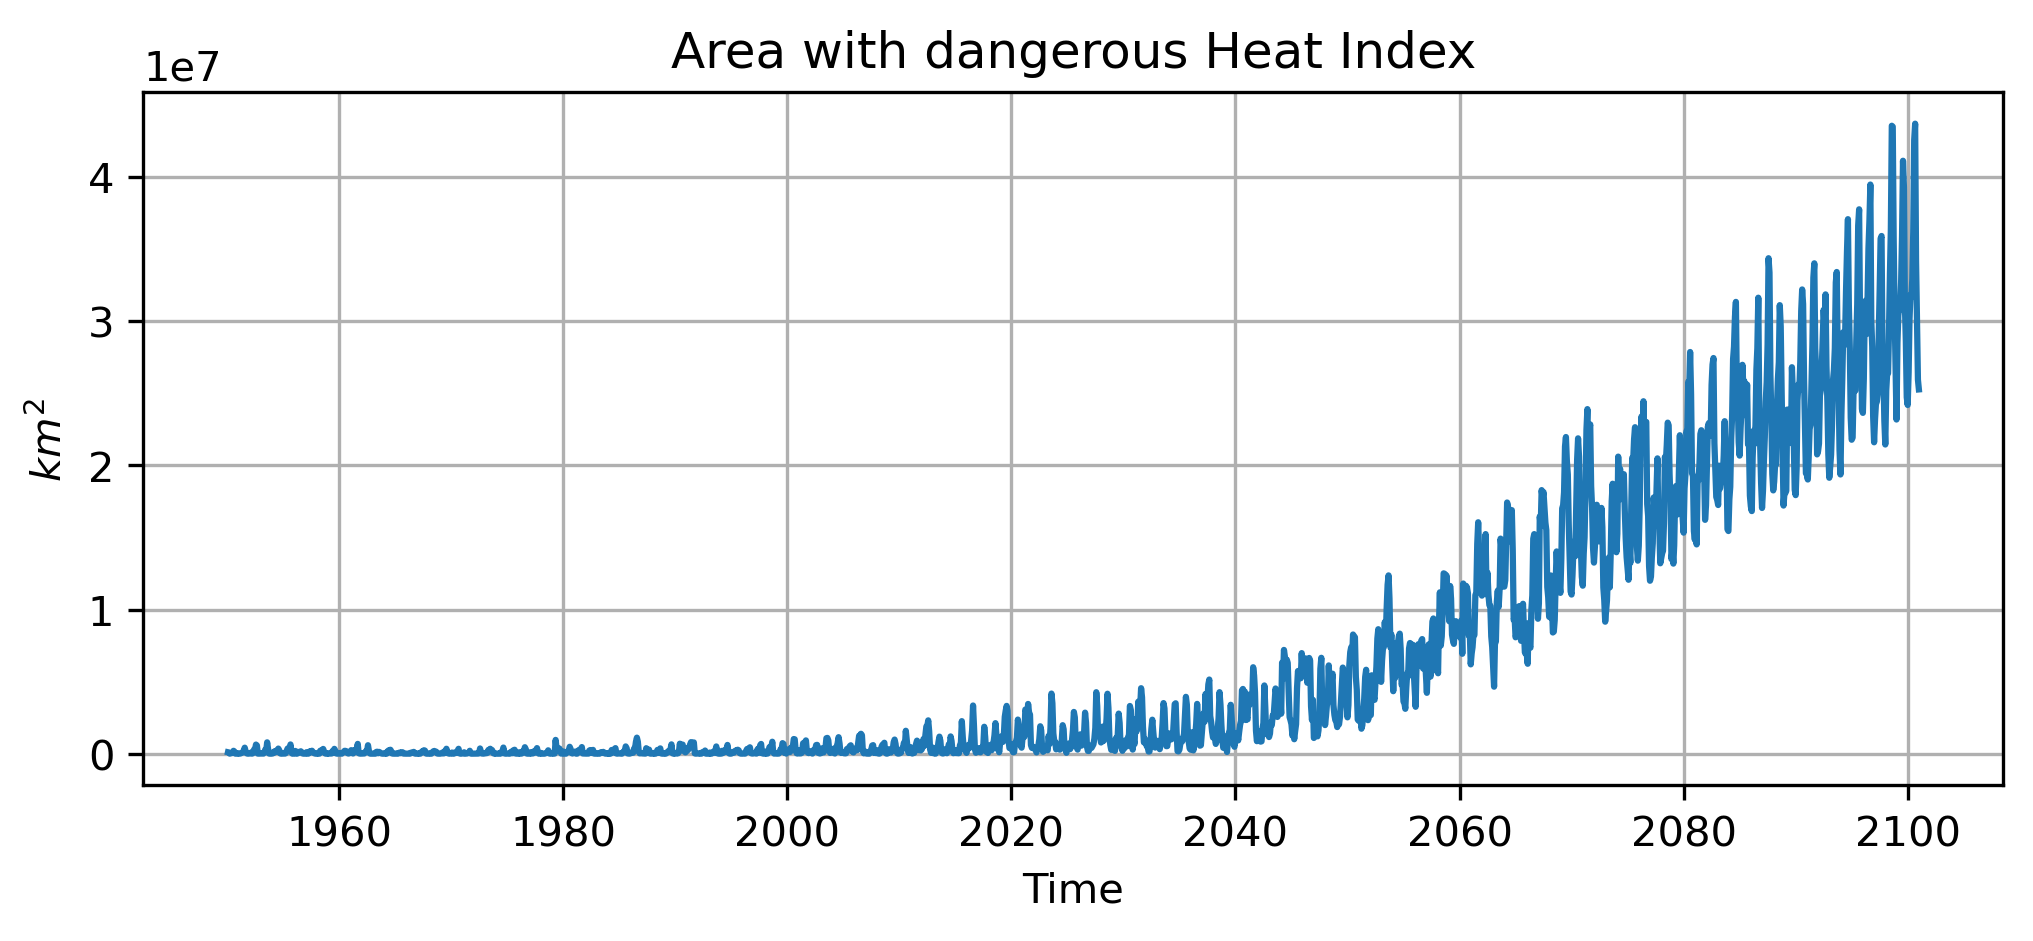

In [30]:
fig,ax = plt.subplots(1,1,figsize=(8,3),dpi=300)

area_.plot(ax=ax)

ax.set_title('Area with dangerous Heat Index')
ax.set_ylabel(r'$km^2$')
ax.set_xlabel('Time')
ax.grid()